# Causal Modeling of Covid-19 Severity by County
### Authors: Chloe Larkin, Ryan Douglas, Srinidhi Gopalakrishnan

This project focuses on identifying the causes of COVID-19 outbreak in a US county and validating each variable's causal effect through analysis of conditioning and interventions on them. This will help suggest appropriate recommendations to individual counties to reduce COVID-19 risk.

This IPython notebook addresses the following components of the causal modeling project -
1. Building a DAG framework that governs conditional probabilities and data generation
2. Validation of the testable implications on data - Check Global Markov Property and Faithfulness Property
3. Convertion of DAG to a generative model in pyro and evidence of parametric assumptions using a posterior predictive check
4. Estimation of causal effects of interest using a do-intervention
5. Implementation of an alternative "traditional"-style estimator of the causal effect and compare to estimator in terms of variance and computational efficiency

## Import required Packages

**Pandas:** Fast, powerful, flexible and easy to use open source data analysis and manipulation tool

**NumPy:** Adds support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays

**NetworkX:** Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks

**Matplotlib:** Comprehensive library for creating static, animated, and interactive visualizations in Python

**pgmpy:** Python library for working with Probabilistic Graphical Models

**pyro:** Universal probabilistic programming language written in Python and supported by PyTorch on the backend. Pyro enables flexible and expressive deep probabilistic modeling, unifying the best of modern deep learning and Bayesian modeling

**Torch:** Supports Tensor computation (like NumPy) with strong GPU acceleration

**xarray:** Open source project that makes working with labelled multi-dimensional arrays simple and efficient

**collections:** Containers that are used to store collections of data, for example, list, dict, set, tuple etc.

In [52]:
import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.pylab as plt
print('matplotlib version: ', mpl.__version__)
import networkx as nx
print('networkx version: ', nx.__version__)
import pandas as pd
print('networkx version: ', nx.__version__)
import pgmpy
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator
print('pgmpy version: ', pgmpy.__version__)
import pyro
import pyro.distributions as dist
from pyro.infer import Importance, EmpiricalMarginal
print('pyro version: ', pyro.__version__)
import torch
print('torch version: ', torch.__version__)
import numpy as np
print('numpy version: ', np.__version__)
import xarray
print('xarray version: ', xarray.__version__)
import collections

matplotlib version:  3.1.1
networkx version:  2.3
networkx version:  2.3
pgmpy version:  0.1.12
pyro version:  1.5.0
torch version:  1.6.0
numpy version:  1.17.3
xarray version:  0.16.2


## Load R Extension for Jupyter Notebooks to access bnlearn package

In [2]:
import rpy2.rinterface 
%load_ext rpy2.ipython
print('rpy2 version: ', rpy2.__version__)

rpy2 version:  3.3.6


## Import R Libraries

bnlearn: R package for learning the graphical structure of Bayesian networks, estimate their parameters and perform some useful inference

Rgraphviz: Provides plotting capabilities for R graph objects

In [4]:
%%R
library(bnlearn);
library(Rgraphviz);

## Load Data Exported from Data Processing Code

In [53]:
# Read in the dataset
data = pd.read_csv("../datasets/dag_data_V3.csv")

# Features Under Consideration

| Variable in Dataset 	|                           Explanation                           	|                       Categories (Also Aliases to Conditional Probability Tables)                      	|
|:-------------------:	|:---------------------------------------------------------------:	|:------------------------------------------------------------------------------------------------------:	|
|         CPL         	| Citizen Political Leaning                                       	| Democrat, Even, Heavily Democrat, Heavily Republican, Leaning Democrat, Leaning Republican, Republican 	|
|         SPL         	| State Government Leaning                                        	| Democratic, Republican                                                                                 	|
|         BLG         	| Ban on Large Gatherings                                         	| Expanded Limit, Gatherings Prohibited, Lifted, New Limit on Large Gatherings in Place                  	|
|          UI         	| Urban Influence                                                 	| Metropolitan, Micropolitan, Noncore                                                                    	|
|         ICU         	| Emergency Preparedness (# ICU Beds per 1000 Habitants)          	| High, Low, Medium, Very High                                                                           	|
|          HS         	| Percentage of Population with No High School Degree             	| High, Low, Medium, Very High, Very Low                                                                 	|
|          MI         	| Median Household Income                                         	| High, Low, Medium, Very High, Very Low                                                                 	|
|         CDC         	| CDC Compliance (Percentage of Population who Always Wear Masks) 	| High, Low, Medium                                                                                      	|
|          CC         	| Proportion of Confirmed COVID Cases (Outcome)                            	| High, Low, Medium, Very High, Very Low                                                                 	|

# Preparing Data

### Construct a DAG model in bnlearn to experiment with faithfulness and d-separation statements

#### Steps to construct DAG in bnlearn:
1. Create a DAG in bnlearn by calling model2network()
2. Plot the DAG to confirm its accuracy in representing the DAG
3. Conduct a d-separation test as a sanity check on the DAG

#### Create DAG in bnlearn

In [6]:
%%R
d_sep <- bnlearn:::dseparation
bnlearn_dag = model2network("[CPL][HS][MI][SPL][UI][BLG|SPL][ICU|UI][CDC|HS:CPL:MI][CC|ICU:CDC:BLG]")

#### Plot the bnlearn DAG

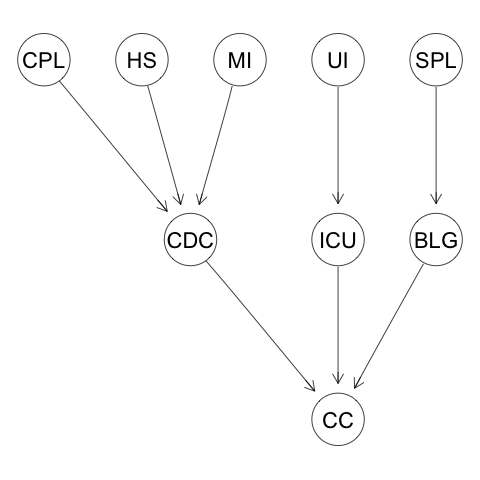

In [7]:
%%R
graphviz.plot(bnlearn_dag)

#### Run d-separation sanity check on the bnlearn DAG: (Should return "FALSE")

In [8]:
%%R
d_sep(bn = bnlearn_dag, x = 'BLG', y = 'CC', z = 'CPL')

[1] FALSE


### Construct a DAG model in Pyro to experiment with interventions and conditional modeling

#### Steps to construct DAG model in Pyro: 
1. Construct a DAG using the pgmpy Python package's BayesianModel method
2. Fit the pgmpy model on the data
3. Extract conditional probability vectors from the pgmpy DAG, and use these as input tensors for a Pyro model

#### Construct a DAG using the pgmpy package.
We will model interventions and inferences on the DAG using the Pyro data science package for Python, but loading the data into a pygmy Bayesian network will allow us to easily transfer large conditional probability tables to Pyro. 

In [54]:
# Create a Bayesian model using pgmpy to represent the DAG.
edges = [('CPL', 'CDC'), ('HS', 'CDC'), ('MI', 'CDC'), ('SPL', 'BLG'),
         ('UI', 'ICU'), ('ICU', 'CC'), ('CDC', 'CC'), ('BLG', 'CC')]

bayes_model = BayesianModel(edges)

#### Plotting DAG using NetworkX

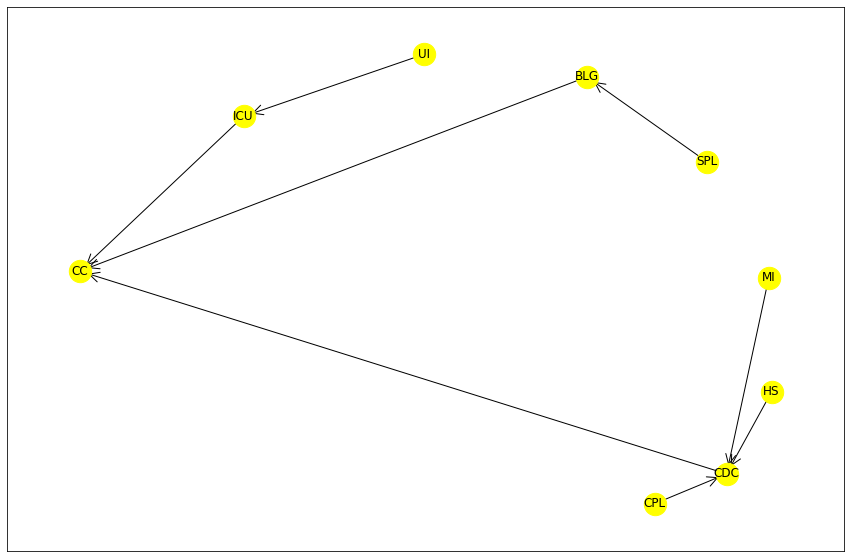

In [5]:
G = nx.DiGraph()
G.add_edges_from(edges)

plt.figure(figsize=(15,10))
pos = nx.spiral_layout(G)
nx.draw_networkx_nodes(G, pos, node_color = 'yellow', node_size = 500)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edgelist = edges, arrows = True, arrowsize=25, arrowstyle='->')
plt.show()

#### Fit the Bayesian model on the cleaned dataset

In [55]:
# Fit the Bayesian model on the dataset.
bayes_model.fit(data)

#### Construct vectors for the Pyro model by extracting conditional probability values from the Bayesian DAG

In [56]:
# Extract labels, probability tables, and a list of incoming variables for each variable in the DAG

# CPL labels and probabilities
cpl_cpd = bayes_model.get_cpds(node="CPL")
cpl_labels, cpl_proba = cpl_cpd.state_names["CPL"], torch.tensor(cpl_cpd.values.T)

#ICU labels, probabilities, and input variables
icu_cpd = bayes_model.get_cpds(node="ICU")
icu_labels, icu_proba = icu_cpd.state_names["ICU"], torch.tensor(icu_cpd.values.T)
icu_input_vars = icu_cpd.variables

# CDC labels, probabilities, and input variables
cdc_cpd = bayes_model.get_cpds(node="CDC")
cdc_labels, cdc_proba = cdc_cpd.state_names["CDC"], torch.tensor(cdc_cpd.values.T)
cdc_input_vars = cdc_cpd.variables

# HS labels and probabilities
hs_cpd = bayes_model.get_cpds(node="HS")
hs_labels, hs_proba = hs_cpd.state_names["HS"], torch.tensor(hs_cpd.values.T)

# MI labels and probabilities
mi_cpd = bayes_model.get_cpds(node="MI")
mi_labels, mi_proba = mi_cpd.state_names["MI"], torch.tensor(mi_cpd.values.T)

# UI labels and probabilities
ui_cpd = bayes_model.get_cpds(node="UI")
ui_labels, ui_proba = ui_cpd.state_names["UI"], torch.tensor(ui_cpd.values.T)

# SPL labels and probabilities
spl_cpd = bayes_model.get_cpds(node="SPL")
spl_labels, spl_proba = spl_cpd.state_names["SPL"], torch.tensor(spl_cpd.values.T)

# BLG labels, probabilities, and input variables
blg_cpd = bayes_model.get_cpds(node="BLG")
blg_labels, blg_proba = blg_cpd.state_names["BLG"], torch.tensor(blg_cpd.values.T)
blg_input_vars = blg_cpd.variables

# CC labels, probabilities, and input variables
cc_cpd = bayes_model.get_cpds(node="CC")
cc_labels, cc_proba = cc_cpd.state_names["CC"], torch.tensor(cc_cpd.values.T)
cc_input_vars = cc_cpd.variables

# Create a variable storing the County Case rates in proper Likert order for plots
reordered_cc = ["Very Low", "Low", "Medium", "High", "Very High"]

cpl_proba

tensor([0.0266, 0.0522, 0.0565, 0.6575, 0.0431, 0.0673, 0.0969],
       dtype=torch.float64)

In [57]:
# Define Label Dictionary with Ordered Categories for Future Plots

labels_dict = {
    'CPL': ['Heavily Republican', 'Republican', 'Leaning Republican', 'Even', 'Leaning Democrat', 'Democrat', 'Heavily Democrat'],
    'ICU': ['Low', 'Medium', 'High', 'Very High'],
    'CDC': ['Low', 'Medium', 'High'],
    'HS': ['Very Low', 'Low', 'Medium', 'High', 'Very High'],
    'MI': ['Very Low', 'Low', 'Medium', 'High', 'Very High'],
    'UI': ['metropolitan', 'micropolitan', 'noncore'],
    'SPL': ['Democratic', 'Republican'],
    'BLG': ['Expanded Limit', 'Gatherings Prohibited', 'Lifted', 'New Limit on Large Gatherings in Place'],
    'CC': ['Very Low', 'Low', 'Medium', 'High', 'Very High']
}

### Construct a Causal Model in Pyro, built upon the conditional probability tables extracted from the pgmpy Bayesian network

In [58]:
def cc_pyro_model():
    '''
    Create model of county COVID case severity from the DAG
    '''
    CPL = pyro.sample("CPL", dist.Categorical(probs=cpl_proba)) 
    HS = pyro.sample("HS", dist.Categorical(probs=hs_proba)) 
    MI = pyro.sample("MI", dist.Categorical(probs=mi_proba)) 
    UI = pyro.sample("UI", dist.Categorical(probs=ui_proba))
    SPL = pyro.sample("SPL", dist.Categorical(probs=spl_proba))
    CDC = pyro.sample("CDC", dist.Categorical(probs=cdc_proba[MI][HS][CPL]))
    ICU = pyro.sample("ICU", dist.Categorical(probs=icu_proba[UI]))
    BLG = pyro.sample("BLG", dist.Categorical(probs=blg_proba[SPL]))
    CC = pyro.sample("CC", dist.Categorical(probs=cc_proba[ICU][CDC][BLG]))
    return{"CPL": CPL, "CDC": CDC, "HS" : HS, "MI": MI, "UI": UI,
           "ICU": ICU, "SPL" : SPL, "BLG" : BLG, "CC" : CC} 

print(cc_pyro_model())

{'CPL': tensor(3), 'CDC': tensor(1), 'HS': tensor(4), 'MI': tensor(0), 'UI': tensor(0), 'ICU': tensor(1), 'SPL': tensor(0), 'BLG': tensor(3), 'CC': tensor(4)}


# Validate Testable Implications on the Data

### Global Markov Property

A joint probability distribution is said to satisfy the Global Markov property with respect to a DAG if every true d-separation in the DAG corresponds to a true conditional independence statement in the joint probability distribution.

### Faithfulness Property

A joint distribution is said to be faithful to a DAG if every true conditional independence statement about the joint distribution corresponds to a true d-separation statement in the DAG.

#### Nonredundant d-separation statements

For a set {Z} that makes 2 nodes X and Y d-separate, if removing any element from Z breaks the d-separation, the statement (X independent of Y given Z) is said to be a nonredundant d-separation statement.

## 1. Test how well the Markov property assumption holds up with this DAG and dataset

#### Create list of all true and nonredundant d-separation statements in the DAG

**Result:** There are 1,792 total true d-separation statements in this DAG, and there are 28 true and nonredundant d-separation statements in this DAG.

In [10]:
%%R
vars <- nodes(bnlearn_dag)
pairs <- combn(x = vars, 2, list)
true_dsep_statements <- list()
nonredundant_dsep_statements <- list()
arg_sets <- list()

# Iterate through each pair of nodes in the DAG
for(pair in pairs) {
  others <- setdiff(vars, pair)
    
  # Iterate through all possible Z sets for d-separating the current pair
  conditioning_sets <- unlist(lapply(0:4, function(.x) combn(others, .x, list)), recursive = F)
  for(set in conditioning_sets){
    xyz <- list(x = pair[1], y = pair[2], z = set)
    arg_sets <- c(arg_sets, list(xyz))
      
    # Check whether this X, Y, Z statement is truly d-separated
    if (d_sep(bn=bnlearn_dag, xyz[[1]], xyz[[2]], xyz[[3]])) {
        
        # If true d-separation statement, add to list of true d-separation statements
        true_dsep_statements <- c(true_dsep_statements, list(xyz));
        
        nonredundant = TRUE;
        
        # Check v-structure d-separation statements, where Z may be empty
        if(length(xyz[[3]]) == 0){ 
            nonredundant = TRUE;
        }
        else{
            
        # Iterate over the node set Z: 
            for(i in 1:length(xyz[[3]])){
                
        # Check d-separation of each Z subset, to see if the set is redundant:
            if (d_sep(bn=bnlearn_dag, xyz[[1]], xyz[[2]], xyz[[3]][-i])){ 
                nonredundant = FALSE;
            }
        }
        }
        
        # If not redundant, then add to list of nonredundant d-separation statements
        if(nonredundant){
            nonredundant_dsep_statements <- c(nonredundant_dsep_statements, list(xyz));
        }
      }
   }
}
sprintf("Number of all true d-separation statements: %d; number of true and non-redundant d-separation statements: %d",
    length(true_dsep_statements), length(nonredundant_dsep_statements))                                 

[1] "Number of all true d-separation statements: 1792; number of true and non-redundant d-separation statements: 28"


#### Print all true, non-redundant d-separation statements in the DAG:

In [11]:
%%R
# Print all nonredundant d-separation statements:
print("Nonredundant d-separation statements in the DAG:")
for(i in 1:length(nonredundant_dsep_statements)){
    printer <- paste(c(nonredundant_dsep_statements[[i]]$x, "⊥", nonredundant_dsep_statements[[i]]$y, "|",
    nonredundant_dsep_statements[[i]]$z), collapse=" ")
    print(printer)
}

[1] "Nonredundant d-separation statements in the DAG:"
[1] "BLG ⊥ CDC |"
[1] "BLG ⊥ CPL |"
[1] "BLG ⊥ HS |"
[1] "BLG ⊥ ICU |"
[1] "BLG ⊥ MI |"
[1] "BLG ⊥ UI |"
[1] "CC ⊥ CPL | CDC"
[1] "CC ⊥ HS | CDC"
[1] "CC ⊥ MI | CDC"
[1] "CC ⊥ SPL | BLG"
[1] "CC ⊥ UI | ICU"
[1] "CDC ⊥ ICU |"
[1] "CDC ⊥ SPL |"
[1] "CDC ⊥ UI |"
[1] "CPL ⊥ HS |"
[1] "CPL ⊥ ICU |"
[1] "CPL ⊥ MI |"
[1] "CPL ⊥ SPL |"
[1] "CPL ⊥ UI |"
[1] "HS ⊥ ICU |"
[1] "HS ⊥ MI |"
[1] "HS ⊥ SPL |"
[1] "HS ⊥ UI |"
[1] "ICU ⊥ MI |"
[1] "ICU ⊥ SPL |"
[1] "MI ⊥ SPL |"
[1] "MI ⊥ UI |"
[1] "SPL ⊥ UI |"


### Determine proportion of true d-separation statements that are also true conditional independence statements:

48.39% of all true d-separation statements are also true conditional independence statements.

In [12]:
%%R
bnlearn_data = read.delim("../datasets/dag_data_V3.csv", sep = ",");
true_cond_indi_count = 0;
true_cond_indi_list <- list()

# Iterate through each nonredundant d-separation statement
for(statement in true_dsep_statements){
    
    # Check that the null hypothesis of conditional independence cannot be rejected 
    ci_test_results = ci.test(statement[[1]], statement[[2]], statement[[3]], data=bnlearn_data); 
    
    # Check the p-value of the null hypothesis rejection
    if(ci_test_results[2] >= 0.05){ 
        true_cond_indi_list <- c(true_cond_indi_list, ci_test_results$data.name)
        true_cond_indi_count = true_cond_indi_count + 1;
    }
}
sprintf("Proportion of true d-sep. statements that are also true conditional independence statements: %d / %d = %f%%", true_cond_indi_count, length(nonredundant_dsep_statements), 
        (true_cond_indi_count/length(true_dsep_statements)*100))

[1] "Proportion of true d-sep. statements that are also true conditional independence statements: 867 / 28 = 48.381696%"


### Interpretation: How well does the Markov Property hold up with this DAG and dataset?

The Markov property states that "every true d-separation statement in DAG G corresponds to a true conditional independence statement in joint probability distribution P." In this DAG, only 48.39% of true d-separation statements correspond to a true conditional independence statement. Thus, the Markov Property does not hold up very well with this DAG and dataset.

## 2. Test how well the faithfulness property holds up with this DAG and dataset

In [13]:
%%R
# Create a list to store true conditional statements 
true_conditional_statements <- list()
true_cond_and_dsep <- list()

# Evaluate whether each variable combination X, Y, {Z} in this DAG produces a true conditional statement
for(set in arg_sets){
    # Evaluate the p-value of the ci.test result for this combination of X, Y, {Z}
    if (ci.test(set[[1]], set[[2]], set[[3]], bnlearn_data)[2] >= 0.05) { 
        # Add the set to the list of true conditional statements
        true_conditional_statements <- c(true_conditional_statements, list(set)) 
        
        # If the set is d-separated, dd the set to the list of true conditional and true d-separation statements
        if (d_sep(bn=bnlearn_dag, set[[1]], set[[2]], set[[3]])) { 
            true_cond_and_dsep = c(true_cond_and_dsep, list(set));
        }
    } 
}

sprintf("Percentage of true conditional independence statements in the data that are also d-separated in the DAG: %f%%", 
        length(true_cond_and_dsep)/length(true_conditional_statements) * 100)

[1] "Percentage of true conditional independence statements in the data that are also d-separated in the DAG: 50.377687%"


### Interpretation: How well does the faithfulness assumption hold up with this DAG and dataset?
A joint distribution P is faithful to the DAG if "every true conditional independence statement about the joint distribution corresponds to a true d-separation statement in the DAG." In this DAG, the percentage of true conditional independence statements that are also d-separated is 50.38%. Thus, the faithfulness assumption does not hold up very well with this DAG and dataset.

# Explore the probabilities of county COVID-19 severity, conditioned on variables of interest

### Define helper functions for efficiently computing conditional probabilities of county COVID-19 case severity

In [67]:
def compute_conditional_prob(model, selected_condition, outcome):
    '''
    Computes the conditional probability of a conditioned model where outcome variable is County COVID severity
    Returns: Proportion of samples in the selected condition of COVID severity on the total number of samples in the 
    given variable's category 
    '''
    A_posterior = pyro.infer.Importance(model, num_samples=10000).run() 
    A_marginal = EmpiricalMarginal(A_posterior, outcome)
    A_samples = [A_marginal().item() for _ in range(10000)]
    A_unique, A_counts = np.unique(A_samples, return_counts=True)
    samples = [s for s in A_samples if s == selected_condition]
    return len(samples)/len(A_samples)

In [68]:
def get_all_conditional_probs(model, var, var_labels):
    '''
    Retrieves a list of all conditional probabilities for county COVID severity, conditioned on one variable
    Returns: Dictionary where keys are covid risk categories and values are the conditional probabilities
    '''

    reordered_cc = ["Very Low", "Low", "Medium", "High", "Very High"]
    proba_dict = {}

    # Iterate through each category of the variable
    for i in range(len(var_labels)):
        conditioned_model = pyro.condition(model, data={var:torch.tensor(i)})
        probability_dict = {}
        
        # Iterate through each covid case rate category
        for j in range(len(cc_labels)):
            probability_dict[cc_labels[j]]= compute_conditional_prob(conditioned_model, j, 'CC')

        # Format probability findings and insert into dictionary
        proba_dict[var_labels[i]] = {i: probability_dict[i] for i in reordered_cc}
    return proba_dict

In [69]:
def plot_all_conditional_probs(proba_dictionary, ax_dims, fig_dims, plot_name, labels):
    '''
    Helper function to plot all conditional probabilities for one variable's conditional effect 
    on county COVID case severity
    '''
    fig, axs = plt.subplots(ax_dims[0], ax_dims[1], figsize=(fig_dims[0], fig_dims[1]))
    fig.suptitle(plot_name + ' vs. COVID Case Rate Probability', fontsize=15)

    category = 0
    
    # Two plotting functions depending on the axis dimensions
    if (ax_dims[0] > 1) & (ax_dims[1] > 1):
        for i in range(ax_dims[0]):
            for j in range(ax_dims[1]):
                if category < len(labels):
                    axs[i, j].plot(list(proba_dictionary[labels[category]].keys()), 
                           list(proba_dictionary[labels[category]].values()), 
                           label = labels[category])
                    axs[i, j].set_title(labels[category])
                    category += 1
    else:
        max_ind = max(ax_dims[0], ax_dims[1])
        for k in range(max_ind):
            if category < len(labels):
                axs[k].plot(list(proba_dictionary[labels[category]].keys()), 
                       list(proba_dictionary[labels[category]].values()), 
                       label = labels[category])
                axs[k].set_title(labels[category])
                category += 1

    for ax in axs.flat:
        ax.set(xlabel='COVID Case Rate Category', ylabel='Probability')
    plt.subplots_adjust(wspace=0.4, hspace = 0.4)
    plt.show()

### Hypothesis 1. (H1) Conditioning the DAG on a county's bans on large gatherings  differentiates counties' COVID-19 case rate outcomes, where counties with stricter bans report lower case rates.

In [72]:
blg_hypothesis_dict = get_all_conditional_probs(cc_pyro_model, 'BLG', blg_labels)
for category in blg_hypothesis_dict:
    print("COVID case rate probabilities for " + category + " large gathering ban category: ", 
          blg_hypothesis_dict[category], "\n")

COVID case rate probabilities for Expanded Limit large gathering ban category:  {'Very Low': 0.2751, 'Low': 0.1898, 'Medium': 0.1707, 'High': 0.1707, 'Very High': 0.2009} 

COVID case rate probabilities for Gatherings Prohibited large gathering ban category:  {'Very Low': 0.304, 'Low': 0.2826, 'Medium': 0.2257, 'High': 0.0745, 'Very High': 0.0875} 

COVID case rate probabilities for Lifted large gathering ban category:  {'Very Low': 0.0807, 'Low': 0.152, 'Medium': 0.2146, 'High': 0.3241, 'Very High': 0.2411} 

COVID case rate probabilities for New Limit on Large Gatherings in Place large gathering ban category:  {'Very Low': 0.2108, 'Low': 0.191, 'Medium': 0.1964, 'High': 0.1836, 'Very High': 0.2264} 



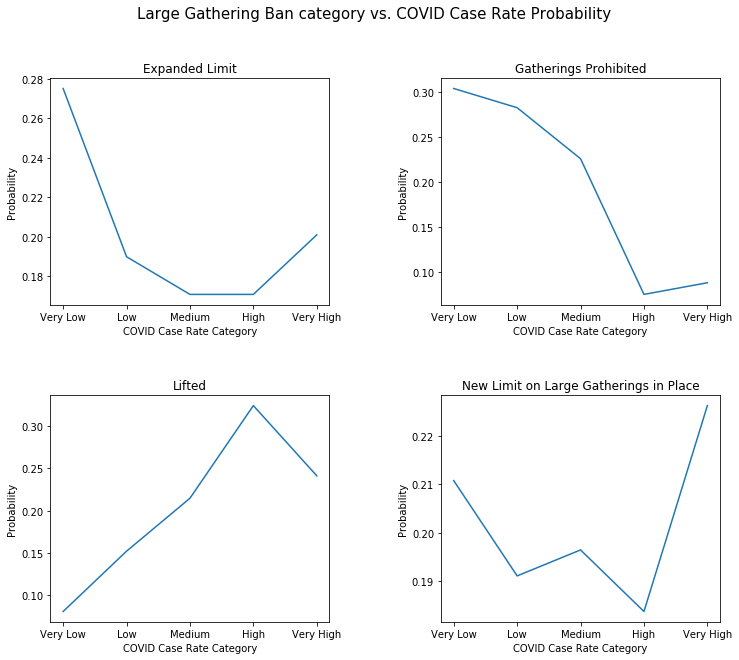

In [73]:
plot_all_conditional_probs(blg_hypothesis_dict, ax_dims=[2, 2], fig_dims=[12, 10], 
                           plot_name="Large Gathering Ban category", labels=blg_labels)

**Result:** These plotted conditional probability distributions are in alignment with hypothesis (H1). When our DAG is conditioned on BLG categories where restrictions are expanded and gatherings are prohibited, the probability distribution of COVID case rate shows lower risk of the disease. In these distributions, the outcome category with highest probability is "Very Low" COVID case rate. On the other hand, the highest-probability COVID case rate outcome when the DAG is conditioned on "bans are lifted" is the "High" case rate category. When conditioned on the ban category of "new limit on large gatherings in place," the case rate outcome "Very High" exceeds the probability of other outcomes. This latter finding intuitively suggests a temporal relationship where counties that have very recently enacted a ban may be more likely to have very high case rates. 

### Hypothesis 2. (H2) Conditioning the DAG on citizen CDC compliance  differentiates counties' COVID-19 case rate outcomes, where counties with greater compliance report lower case rates.

In [74]:
cdc_hypothesis_dict = get_all_conditional_probs(cc_pyro_model, 'CDC', cdc_labels)
for category in cdc_hypothesis_dict:
    print("COVID case rate probabilities for " + category + " CDC compliance category: ", 
          cdc_hypothesis_dict[category], "\n")

COVID case rate probabilities for High CDC compliance category:  {'Very Low': 0.2758, 'Low': 0.1969, 'Medium': 0.1756, 'High': 0.2282, 'Very High': 0.1393} 

COVID case rate probabilities for Low CDC compliance category:  {'Very Low': 0.1224, 'Low': 0.158, 'Medium': 0.2181, 'High': 0.1956, 'Very High': 0.2948} 

COVID case rate probabilities for Medium CDC compliance category:  {'Very Low': 0.1873, 'Low': 0.1976, 'Medium': 0.2201, 'High': 0.2178, 'Very High': 0.2053} 



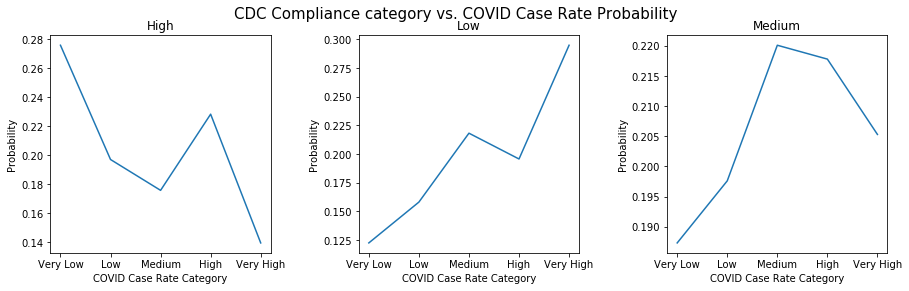

In [75]:
plot_all_conditional_probs(cdc_hypothesis_dict, ax_dims=[1, 3], fig_dims=[15, 4], 
                           plot_name="CDC Compliance category", labels=cdc_labels)

**Result:** When we condition county COVID case rates on residents' adherence to CDC guidelines, the plotted conditional probability distributions are in agreement with (H2). When the DAG is conditioned such that CDC compliance is "High," the COVID case rate outcome with highest probability is "Very Low" case rate. On the other hand, when the DAG is conditioned on "Low" CDC compliance, the outcome with the highest probability is "Very High" case rate. 

### Hypothesis 3. Conditioning the DAG on a county's citizens' political leanings differentiates counties' COVID-19 case rate outcomes.


In [78]:
cpl_hypothesis_dict = get_all_conditional_probs(cc_pyro_model, 'CPL', cpl_labels)
for category in cpl_hypothesis_dict:
    print("COVID case rate probabilities for " + category + " Citizen Political Leaning category: ", 
          cpl_hypothesis_dict[category], "\n")

COVID case rate probabilities for Democrat Citizen Political Leaning category:  {'Very Low': 0.2407, 'Low': 0.1947, 'Medium': 0.1826, 'High': 0.2127, 'Very High': 0.1811} 

COVID case rate probabilities for Even Citizen Political Leaning category:  {'Very Low': 0.221, 'Low': 0.1911, 'Medium': 0.191, 'High': 0.1956, 'Very High': 0.1806} 

COVID case rate probabilities for Heavily Democrat Citizen Political Leaning category:  {'Very Low': 0.2483, 'Low': 0.1847, 'Medium': 0.1749, 'High': 0.2056, 'Very High': 0.1673} 

COVID case rate probabilities for Heavily Republican Citizen Political Leaning category:  {'Very Low': 0.1762, 'Low': 0.1774, 'Medium': 0.2025, 'High': 0.2152, 'Very High': 0.2248} 

COVID case rate probabilities for Leaning Democrat Citizen Political Leaning category:  {'Very Low': 0.2571, 'Low': 0.1906, 'Medium': 0.1897, 'High': 0.2134, 'Very High': 0.1622} 

COVID case rate probabilities for Leaning Republican Citizen Political Leaning category:  {'Very Low': 0.2305, 'Low

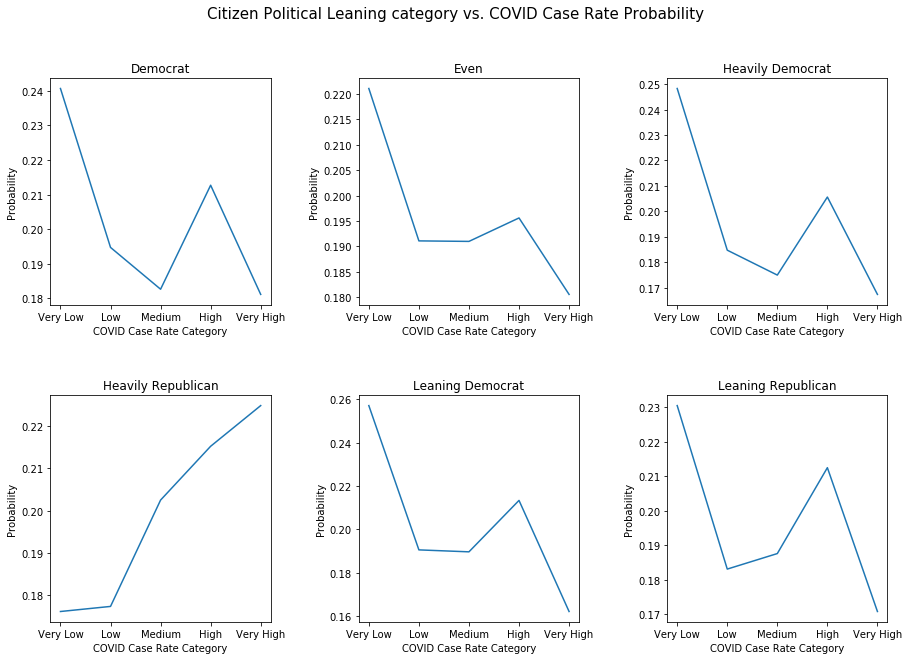

In [79]:
plot_all_conditional_probs(cpl_hypothesis_dict, ax_dims=[2, 3], fig_dims=[15, 10], 
                           plot_name="Citizen Political Leaning category", labels=cpl_labels)

**Result:** Conditioning the DAG on citizen political leaning being "Heavily Republican" produced a conditional probability distribution that was in stark contrast from distributions conditioned on every other citizen political leaning category, in support of (H3). Unlike the other five distributions pictured in the above figure, the COVID case rate category in the conditional probability distribution given CPL = "Heavily Republican" (bottom right graph) showed that the highest-probability case rates were, in order, from most severe to least severe.

### Hypothesis 4. Conditioning the DAG on a county's state leadership political leanings differentiates counties' COVID-19 case rate outcomes.


In [80]:
spl_hypothesis_dict = get_all_conditional_probs(cc_pyro_model, 'SPL', spl_labels)
for category in spl_hypothesis_dict:
    print("COVID case rate probabilities for " + category + " State Political Leaning category: ", 
          spl_hypothesis_dict[category], "\n")

COVID case rate probabilities for Democratic State Political Leaning category:  {'Very Low': 0.2198, 'Low': 0.192, 'Medium': 0.202, 'High': 0.1852, 'Very High': 0.1927} 

COVID case rate probabilities for Republican State Political Leaning category:  {'Very Low': 0.1855, 'Low': 0.1738, 'Medium': 0.1979, 'High': 0.2399, 'Very High': 0.2175} 



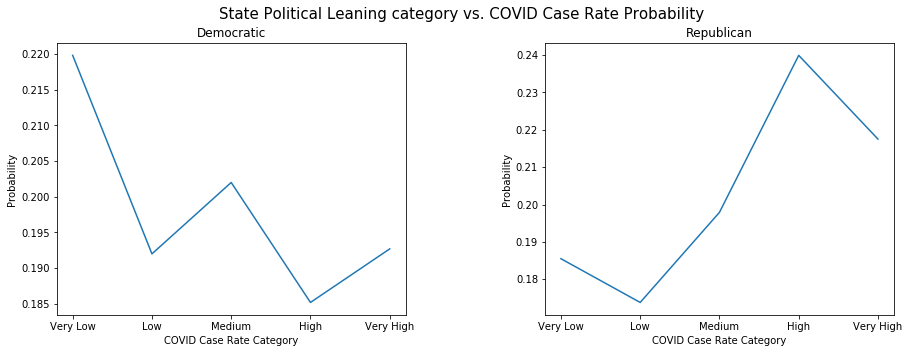

In [87]:
plot_all_conditional_probs(spl_hypothesis_dict, ax_dims=[1, 2], fig_dims=[15, 5], 
                           plot_name="State Political Leaning category", labels=spl_labels)

**Result:** Conditional probability findings support (H4). There is a visual difference in the plots of the conditional probability distributions of COVID case rate when conditioning state political leaning as Democrat vs. Republican. Among outcomes generated when SPL is conditioned as "Democratic," the outcome category "Very Low" has the highest probability; among samples generated when SPL is conditioned as "Republican," the most likely COVID case rate outcome is "High," followed by "Very High."

### Hypothesis 5. Conditioning the DAG on a county's median income category differentiates counties' COVID-19 case rate outcomes; counties where citizens have greater median financial means will have an advantage.

In [90]:
mi_hypothesis_dict = get_all_conditional_probs(cc_pyro_model, 'MI', mi_labels)
for category in mi_hypothesis_dict:
    print("COVID case rate probabilities for " + category + " Median Income category: ", 
          mi_hypothesis_dict[category], "\n")

COVID case rate probabilities for High Median Income category:  {'Very Low': 0.1984, 'Low': 0.1845, 'Medium': 0.2033, 'High': 0.201, 'Very High': 0.2027} 

COVID case rate probabilities for Low Median Income category:  {'Very Low': 0.1824, 'Low': 0.1678, 'Medium': 0.2145, 'High': 0.206, 'Very High': 0.2227} 

COVID case rate probabilities for Medium Median Income category:  {'Very Low': 0.1898, 'Low': 0.1777, 'Medium': 0.1986, 'High': 0.2037, 'Very High': 0.2146} 

COVID case rate probabilities for Very High Median Income category:  {'Very Low': 0.217, 'Low': 0.1936, 'Medium': 0.1945, 'High': 0.2049, 'Very High': 0.1967} 

COVID case rate probabilities for Very Low Median Income category:  {'Very Low': 0.1848, 'Low': 0.1817, 'Medium': 0.2038, 'High': 0.2182, 'Very High': 0.2225} 



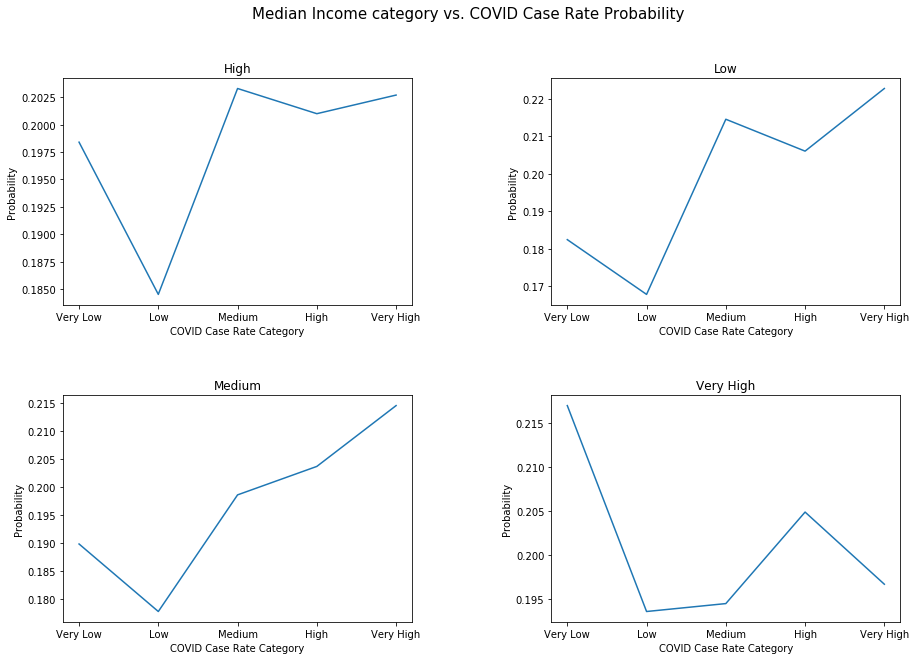

In [94]:
plot_all_conditional_probs(mi_hypothesis_dict, ax_dims=[2, 2], fig_dims=[15, 10], 
                           plot_name="Median Income category", labels=mi_labels)

**Finding:**  When the DAG is conditioned such that Median Income = "Very High," the outcome category of "Very Low" case rate achieves the highest probability in the resulting conditional distribution. In all other categories of median income, the outcome categories with highest probability are Medium to Very High. This finding suggests that counties with "Very High" median income tend to have the best COVID case rate outcomes, supporting (H5).  

# Show evidence of Parametric Assumptions using a Posterior Predictive Check

Here, the distributions of the sampled data from the model are compared to the posterior probability distributions present in the data. The comparisons would give an indication of how 'true' the sampled distribution is. Ideally, the two should be very similar to each other. The plots below show the check for all 8 edges present in the DAG.

In [125]:
### Sample Conditional Probabilities for any variable
def sample_conditional_probs(model, var_given, var_given_labels, var_est, var_est_labels):
    '''
    Retrieves a list of all conditional probabilities for a variable, conditioned on another variable
    Returns: A dictionary where keys are categories in the estimated variable and values are the conditional probabilities
    '''
    proba_dict = {}

    # Iterate through each category of the variable
    for i in range(len(var_given_labels)):
        conditioned_model = pyro.condition(model, data={var_given:torch.tensor(i)})
        probability_dict = {}
        
        # Iterate through each category
        for j in range(len(var_est_labels)):
            probability_dict[var_est_labels[j]]= compute_conditional_prob(conditioned_model, j, var_est)

        # Format probability findings and insert into dictionary
        proba_dict[var_given_labels[i]] = {i: probability_dict[i] for i in var_est_labels}
    return proba_dict

In [131]:
### Posterior Probabilities
def get_post_probs(var_given, var_est, ax_dims, fig_dims):
    
    # Get the correct order of categories from labels_dict for given and estimated variable
    labels_given = labels_dict[var_given]
    labels_est = labels_dict[var_est]
    
    # Create dictionary with posterior conditional probabilities - var_est given var_given
    posterior_prob_dict = {}
    for x in labels_given:
        posterior_prob_dict[x] = {}
        for y in labels_est:
            posterior_prob_dict[x][y] = data[(data[var_given] == x) & 
                                             (data[var_est] == y)].shape[0] / data[data[var_given] == x].shape[0]
    
    # Create dictionary with conditional probabilities from generated samples
    sample_prob_dict = sample_conditional_probs(cc_pyro_model, var_given, labels_given, var_est, labels_est)
    
    # Plot both posterior and sample probabilities in same plot
    fig, axs = plt.subplots(ax_dims[0], ax_dims[1], figsize=(fig_dims[0], fig_dims[1]))
    fig.suptitle(var_est + ' given ' + var_given, fontsize=15)
    
    category = 0
    
    if (ax_dims[0] > 1) & (ax_dims[1] > 1):
        for i in range(ax_dims[0]):
            for j in range(ax_dims[1]):
                if category < len(labels_given):
                    axs[i, j].plot(list(posterior_prob_dict[labels_given[category]].keys()), 
                           list(posterior_prob_dict[labels_given[category]].values()), 
                           label = 'Posterior Prob')
                    axs[i, j].plot(list(sample_prob_dict[labels_given[category]].keys()), 
                           list(sample_prob_dict[labels_given[category]].values()), 
                           label = 'Model-Generated Prob')
                    axs[i, j].set_title(labels_given[category])
                    category += 1
    else:
        max_ind = max(ax_dims[0], ax_dims[1])
        for k in range(max_ind):
            if category < len(labels_given):
                axs[k].plot(list(posterior_prob_dict[labels_given[category]].keys()), 
                       list(posterior_prob_dict[labels_given[category]].values()), 
                       label = 'Posterior Prob')
                axs[k].plot(list(sample_prob_dict[labels_given[category]].keys()), 
                           list(sample_prob_dict[labels_given[category]].values()), 
                           label = 'Model-Generated Prob')
                axs[k].set_title(labels_given[category])
                category += 1

    for ax in axs.flat:
        ax.set(xlabel= var_est, ylabel= 'Probability')
        ax.legend(loc = 'best')
    plt.subplots_adjust(wspace=0.4, hspace = 0.4)
    plt.show()

In [132]:
# List all edges in DAG
edges

[('CPL', 'CDC'),
 ('HS', 'CDC'),
 ('MI', 'CDC'),
 ('SPL', 'BLG'),
 ('UI', 'ICU'),
 ('ICU', 'CC'),
 ('CDC', 'CC'),
 ('BLG', 'CC')]

No handles with labels found to put in legend.


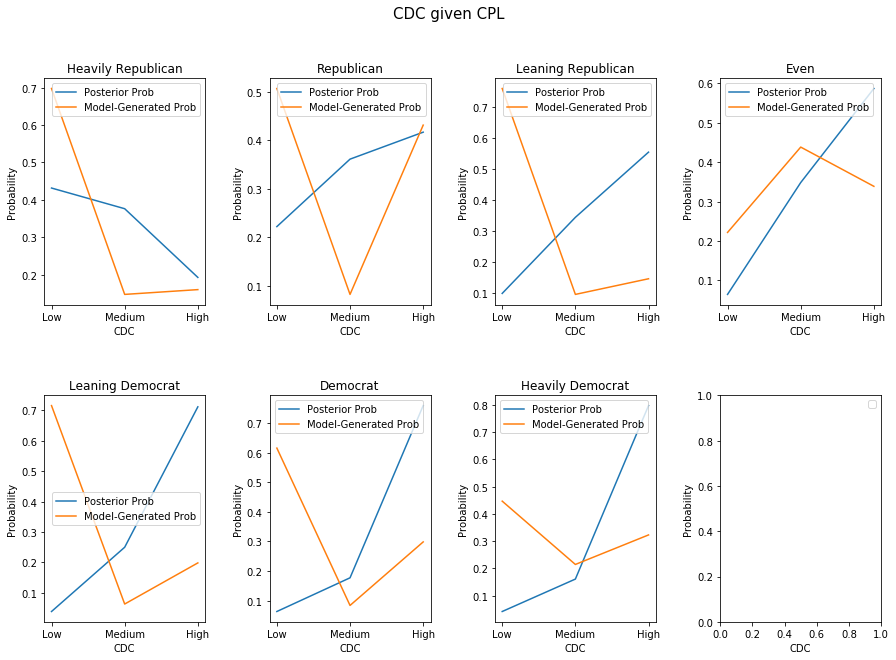

No handles with labels found to put in legend.


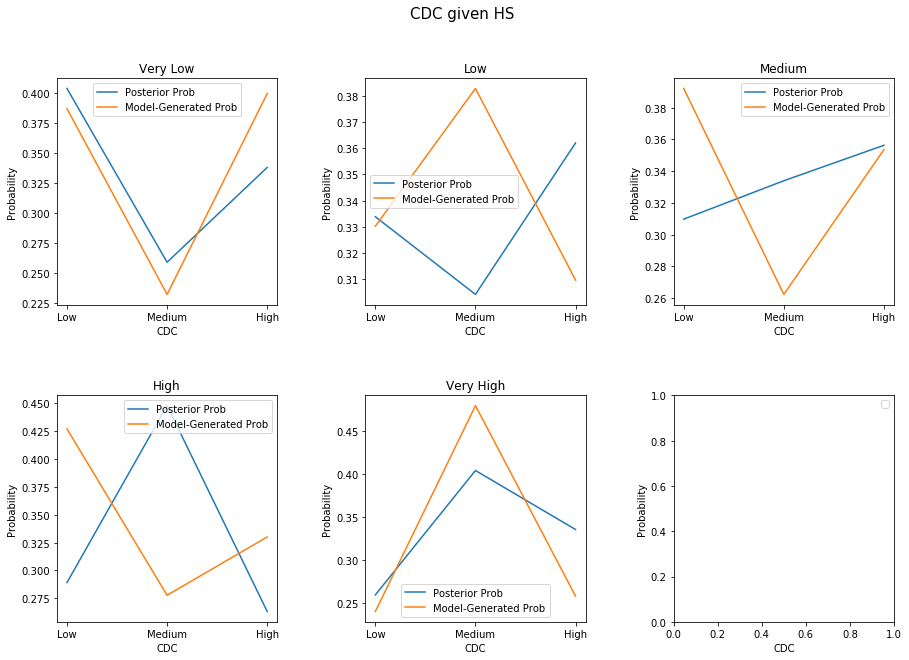

No handles with labels found to put in legend.


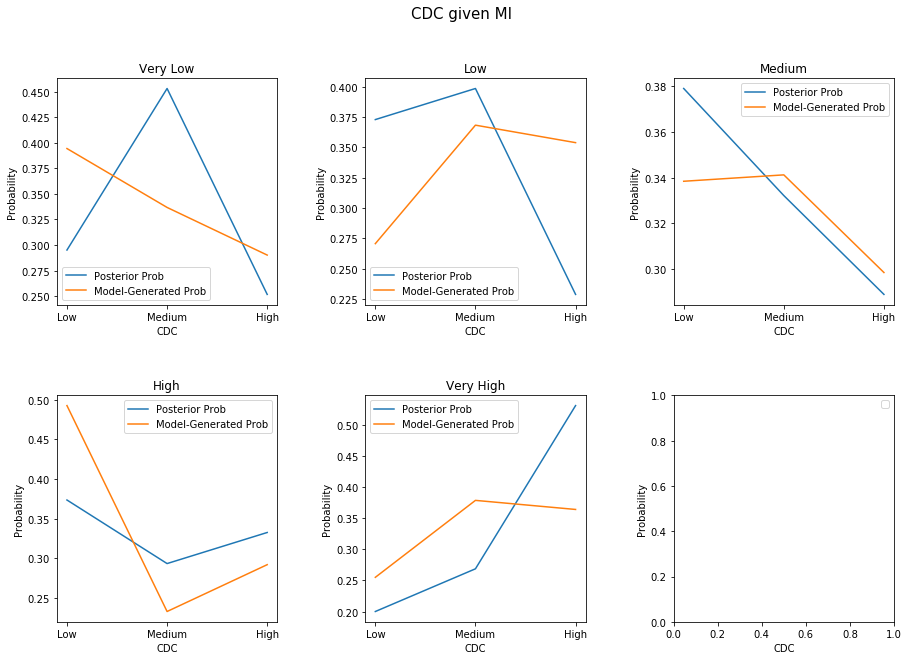

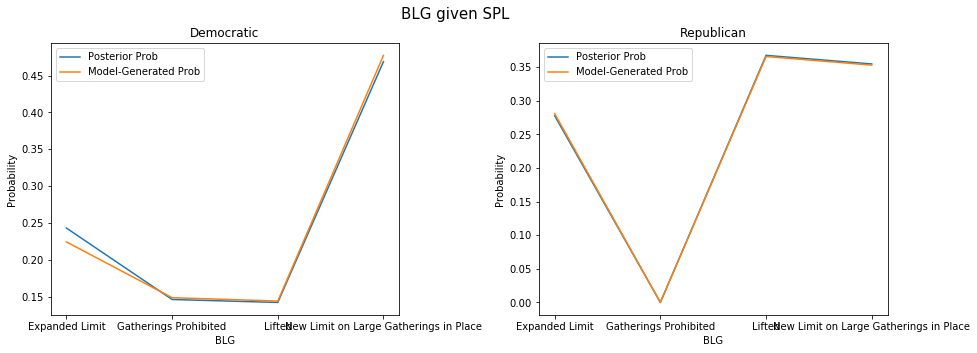

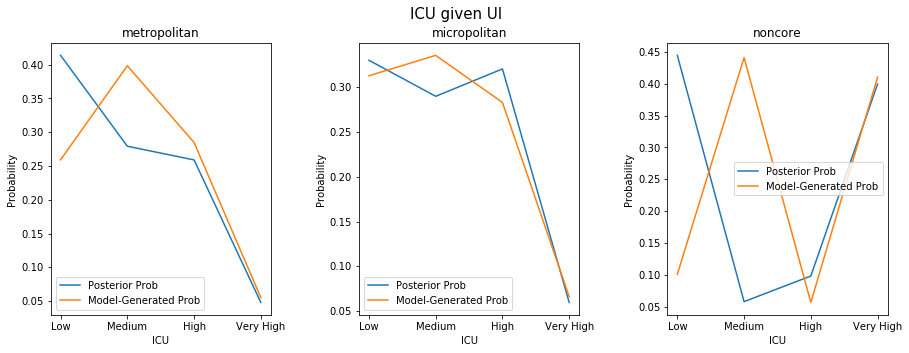

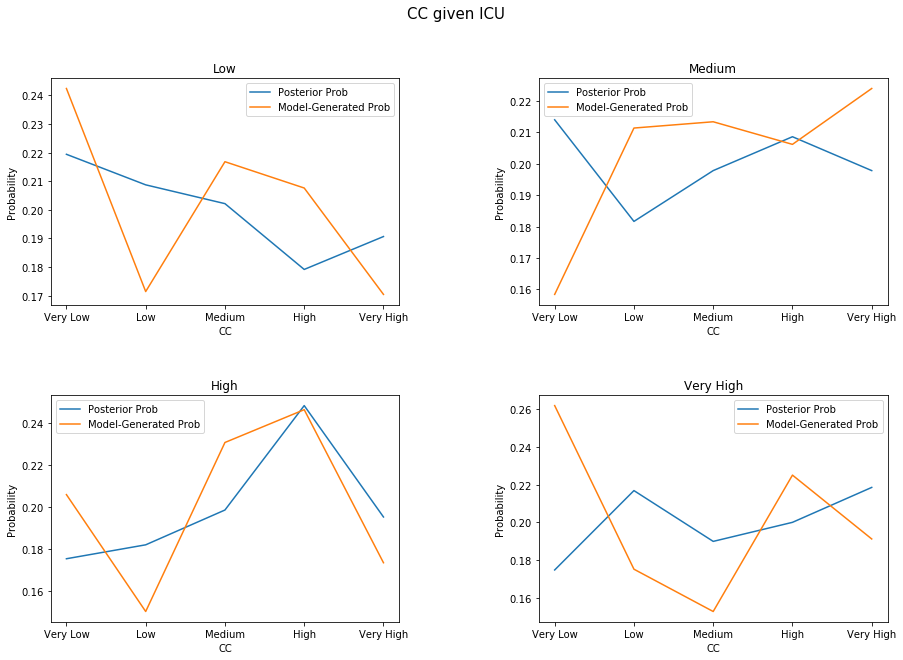

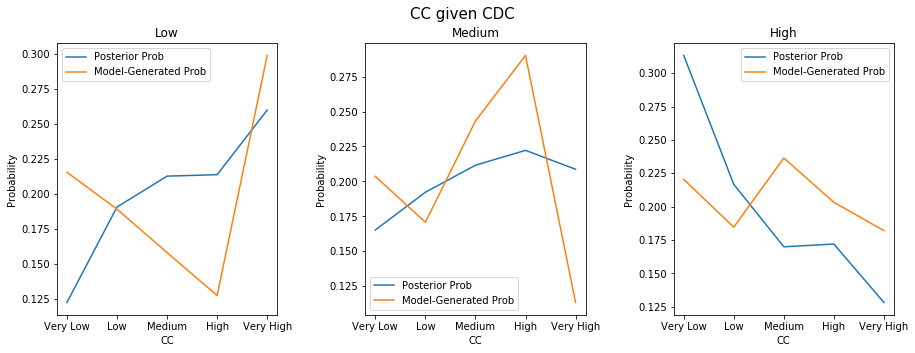

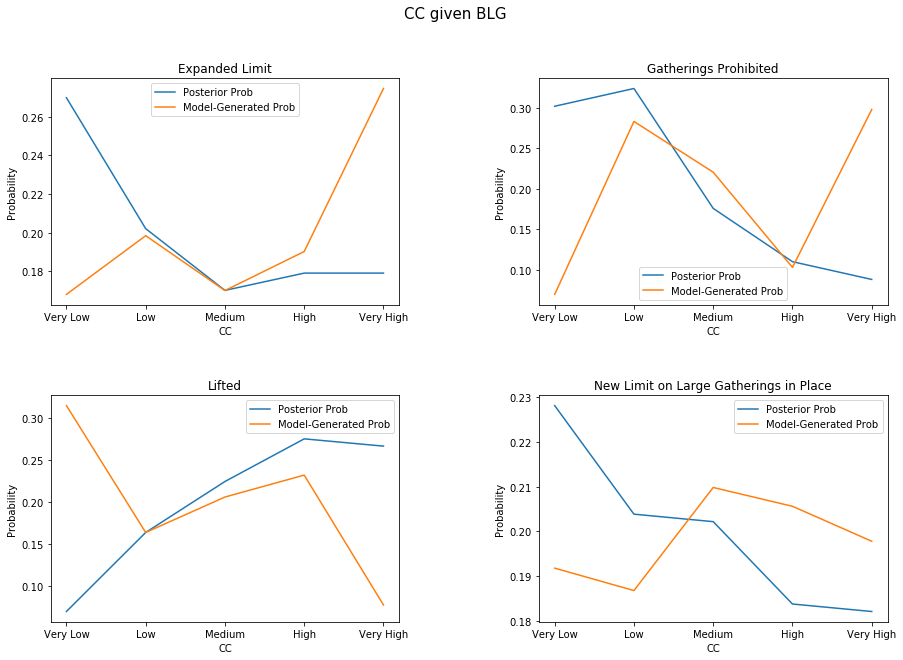

In [133]:
# Plot Posterior conditional probabilities vs. Generated sample conditional probabilities for each edge

get_post_probs(var_given = 'CPL', var_est = 'CDC', ax_dims = [2, 4], fig_dims = [15, 10])
print('\n')
get_post_probs(var_given = 'HS', var_est = 'CDC', ax_dims = [2, 3], fig_dims = [15, 10])
print('\n')
get_post_probs(var_given = 'MI', var_est = 'CDC', ax_dims = [2, 3], fig_dims = [15, 10])
print('\n')
get_post_probs(var_given = 'SPL', var_est = 'BLG', ax_dims = [1, 2], fig_dims = [15, 5])
print('\n')
get_post_probs(var_given = 'UI', var_est = 'ICU', ax_dims = [1, 3], fig_dims = [15, 5])
print('\n')
get_post_probs(var_given = 'ICU', var_est = 'CC', ax_dims = [2, 2], fig_dims = [15, 10])
print('\n')
get_post_probs(var_given = 'CDC', var_est = 'CC', ax_dims = [1, 3], fig_dims = [15, 5])
print('\n')
get_post_probs(var_given = 'BLG', var_est = 'CC', ax_dims = [2, 2], fig_dims = [15, 10])

**Result:** Though the check does show that the posterior conditional probabilities lead to similar sample probabilities for some of the relationships like 'BLG given SPL' and 'ICU given UI', there are a fair amount of differences in the distributions of other plots. Hence, the generated samples are not representative of the existing data. This could be due to lack of data for all combinations of variables.

# Estimating Causal Effects on COVID severity with do-interventions

The do-intervention forces particular variables in the DAG to a single value. In so doing, the intervention blocks the influence from the variable's parents, such that the variable is now statistically independent of its causes.

Here, we perform a do-intervention on each of the 8 variables in the DAG (other than the outcome) and see the effects on COVID risk. 

In [12]:
def plot_model(unique, counts, title, alias, x_label="COVID severity"):
    """
    Plots the output of generative model
    """
    plt.bar(unique, counts, align='center', alpha=0.5)
    plt.xticks(unique, alias)
    plt.ylabel('count')
    plt.xlabel(x_label)
    plt.title(title)
    plt.show()
    
    
def do_importance_sampling(model, intervention, marginal="CC", n_samples=5000, alias=reordered_cc):
    """
    Performs importance sampling given a model and variable of interest and plots the sampled distribution
    """

    posterior = pyro.infer.Importance(model, num_samples=n_samples).run()
    marginal = EmpiricalMarginal(posterior, marginal)
    samples = [marginal().item() for _ in range(n_samples)]
    unique, counts = np.unique(samples, return_counts=True)
    
    plot_model(unique, counts, intervention, alias)
    
def brute_force_intervention(model, variable, labels):
    """
    Performs do interventions for all categories of a given variable and plots the new distribution
    of COVID severity for each new model via importance sampling
    """
    
    for label in labels:
        index = labels.index(label)
        
        do_model = pyro.do(cc_pyro_model, data={variable:torch.tensor(index)})
        intervention = f"P(CC | do({variable} = '{label}'))"
        do_importance_sampling(do_model, intervention)

### Base Model COVID Severity Distribution - Without any Interventions

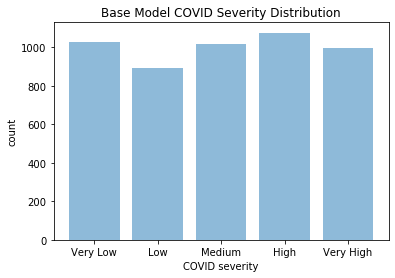

In [102]:
samples = [cc_pyro_model()['CC'] for _ in range(5000)]
unique, counts = np.unique(samples, return_counts=True)

plot_model(unique, counts, title="Base Model COVID Severity Distribution", alias=reordered_cc)

We observe that the number of samples belonging to each category is roughly the same, since we have defined the bins to be so.

### CDC compliance intervention

CDC guidelines compliance is an obvious candidate for a variable that should have a causal effect on COVID severity. 

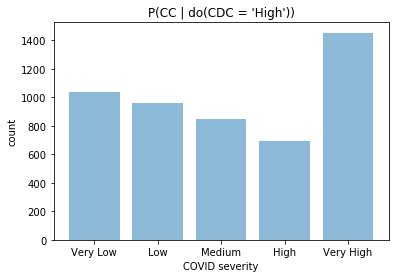

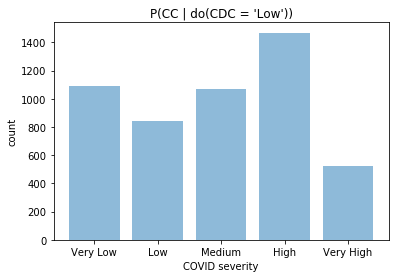

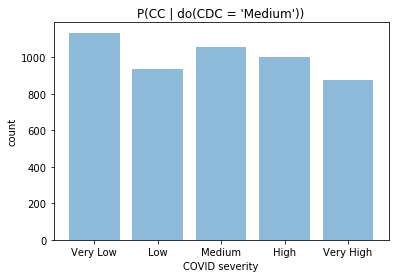

In [103]:
brute_force_intervention(cc_pyro_model, 'CDC', cdc_labels)

**Result:** Contrary to what was observed when we conditioned on CDC (higher CDC compliance leads to lower risk of Covid), the plots show the opposite trend with the most samples for 'Very High' Covid risk when CDC compliance is high. The plot with low CDC compliance, though has low number of samples for 'Very High' covid risk, shows maximum number of samples for 'High' Covid risk, which is in line with our hypothesis. A future next step could be to reduce the number of bins in the outcome variable to make the analysis more interpretable and avoid plots that show contradictory results.

### Ban on Large Gatherings Intervention

We hypothesize that counties that have stricter rules on large gatherings will be less likely to be severely impacted by COVID.

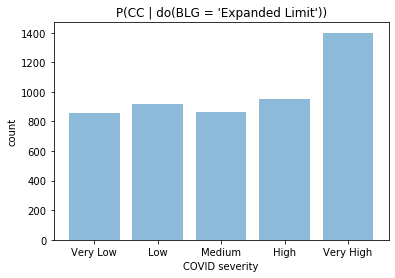

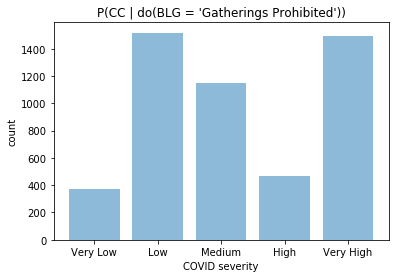

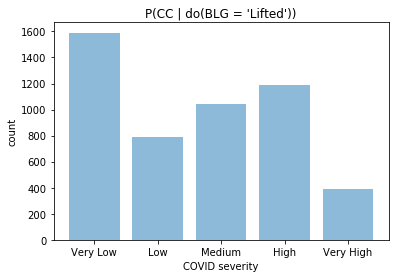

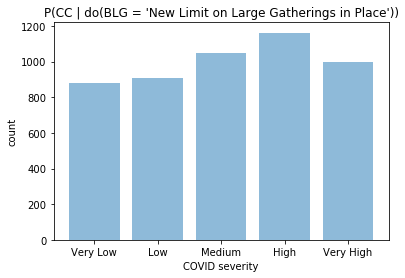

In [104]:
brute_force_intervention(cc_pyro_model, 'BLG', blg_labels)

**Result:** Similar to CDC compliance, an intervention on banning large gatherings shows results different from conditioning on it. For example, in the 'BLG = Lifted' plot, there are a large number of samples indicating 'Very Low' Covid risk. And 'BLG = Expanded Limit' is supposed to result in lower risk but the plot shows otherwise. 'BLG = Gatherings Prohibited' show high numbers for 'Low' and 'Very High' Covid risk, making it difficult to interpret.

### Emergency Preparedness Intervention

We hypothesize that counties that were better prepared for COVID, as measured by number of ICU beds per 1000 habitats, will be less likely to be heavily impacted by COVID.

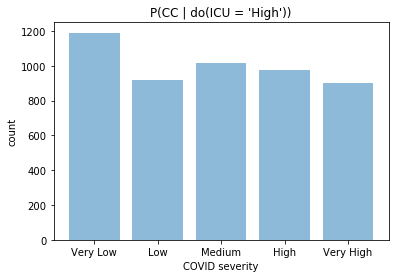

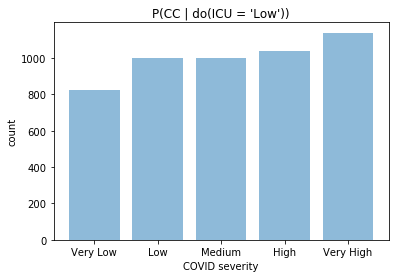

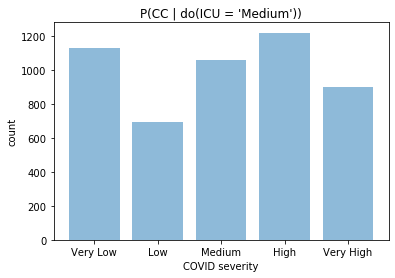

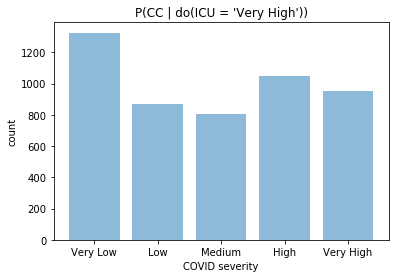

In [105]:
brute_force_intervention(cc_pyro_model, 'ICU', icu_labels)

**Result:** Looking at the 'High', 'Very High' and 'Low' ICU plots, there is a strong agreement to our initial hypothesis that higher number of ICU beds leads to better preparedness by county and lower risk, even though conditioning on ICU did not produce the same results. 

### Political Leaning Intervention

The handling of COVID has become a politically divisive issue in the US. We hypothesize that political orientation, both at a state and county level, will have an effect on COVID severity.

#### State Government Political Party Intervention

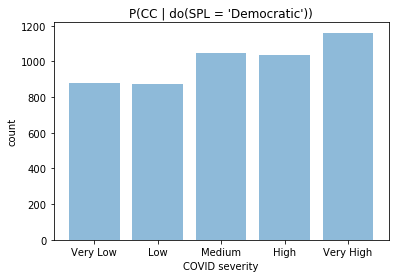

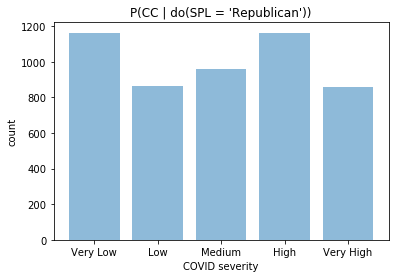

In [106]:
brute_force_intervention(cc_pyro_model, 'SPL', spl_labels)

**Result:** Though we hypothesize that a left-leaning political orientation has an effect on lowering Covid risk rates, the risk rate increases steadily when the state governor is Democratic, though no clear trend is observed when the state governor is Republican (With high number of samples for 'Very Low' and 'High' risk).

#### County Level Political Leaning

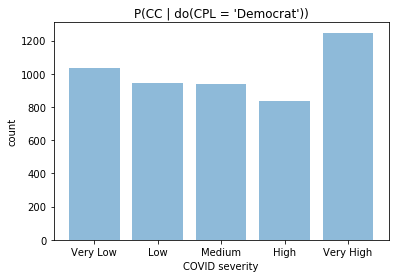

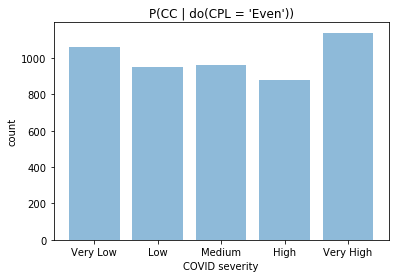

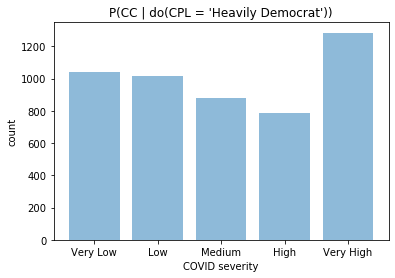

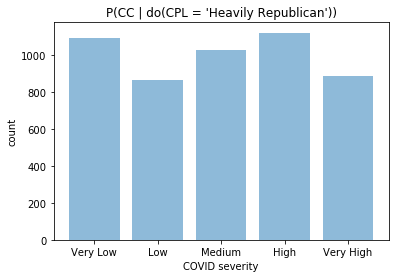

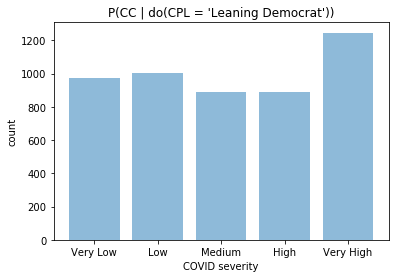

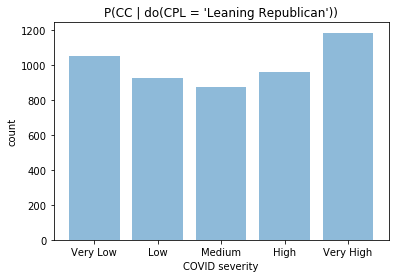

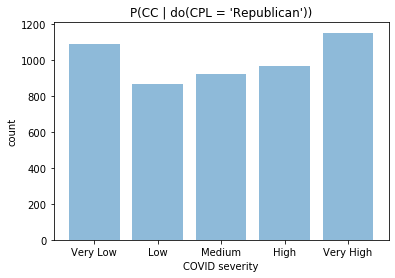

In [107]:
brute_force_intervention(cc_pyro_model, 'CPL', cpl_labels)

**Result:** For the plots where the citizen political leaning is Democratic, we see a trend of decreasing covid risk (numbers reduce as we move from 'Very Low' to 'High' risk), though the probability of 'Very High' risk breaks this trend. For counties citizens who are 'Leaning Republican' and 'Republican', there is a visible upward trend in covid risk, ignoring the 'Very Low' risk cases. This is inline with the hypothesis that a more left-leaning political orientation leads to lower Covid risk.

### Urban Influence Intervention

Urban influence codes take into account things such as population size and size of the counties largest city. We hypothesize that Metropolitan counties will be more likely to be severely impacted by COVID. 

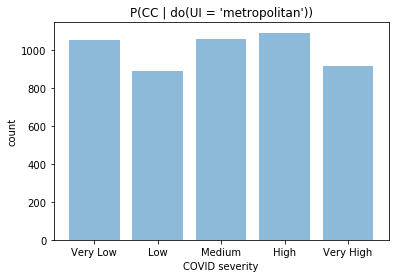

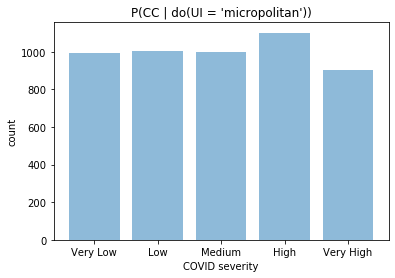

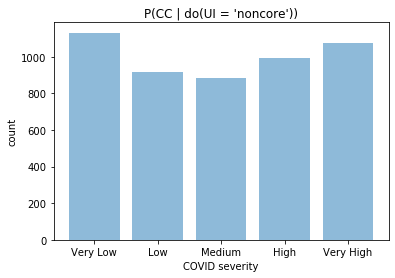

In [108]:
brute_force_intervention(cc_pyro_model, 'UI', ui_labels)

**Result:**  No clear trends of Covid risk are observed when we modify the urban influence among the three categories, though we hypothesize that Metropolitan areas are more densely populated and will be more susceptible to severe COVID outbreaks.

### High School Degree Intervention

An educated populace is a major defense against COVID. We hypothesize that a less educated populace (measured here by % of population with a high school diploma) is more likely to be more severely affected by COVID.

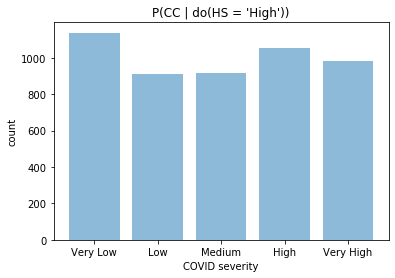

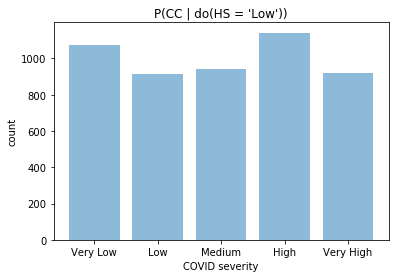

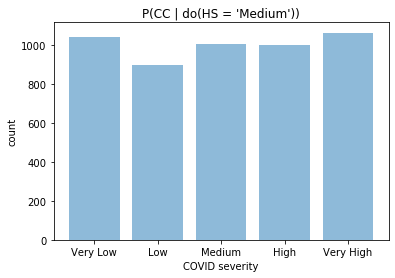

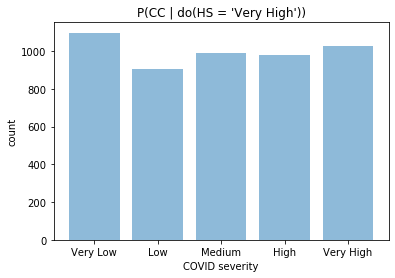

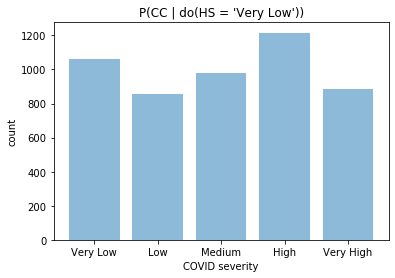

In [109]:
brute_force_intervention(cc_pyro_model, 'HS', hs_labels)

**Result:** No clear indication that higher the percentage of less-educated population, higher the risk of Covid.

### Median Household Income Intervention

Lower income households are at a higher risk of COVID. We hypthosize that counties with a lower median household income will have a greater risk of being heavily impacted by COVID.

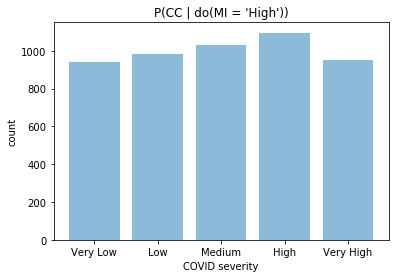

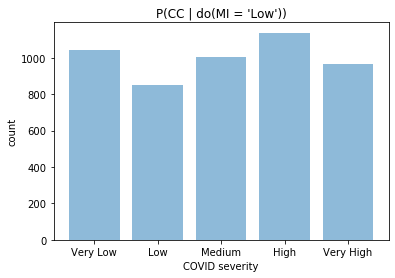

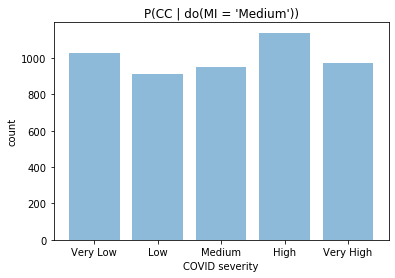

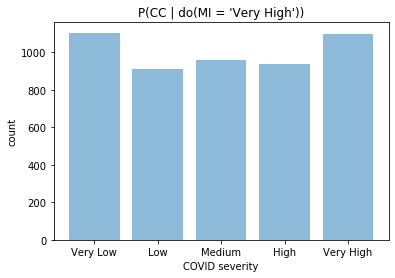

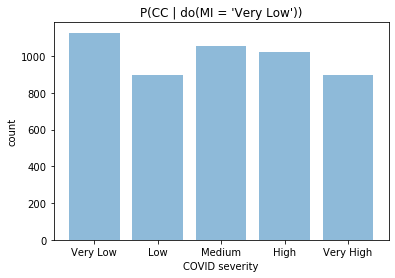

In [110]:
brute_force_intervention(cc_pyro_model, 'MI', mi_labels)

**Result:** The hypothesis is that lower the median income, higher the risk of disease. The plots for different levels of median income are very similar to each other. However, when median income is 'Very Low', there is a clear downward trend of Covid risk, which is contradictory to our hypothesis.

### Multi-variable do-interventions

We had mixed results from our single variable do-interventions but maybe we'll get better results by focusing on the variables that lead directly into COVID severity. Since performing a do-operation on a node eliminates the influence of its parent nodes, we can effectively simplify our model by intervening on combinations of CDC, ICU, and BLG nodes.

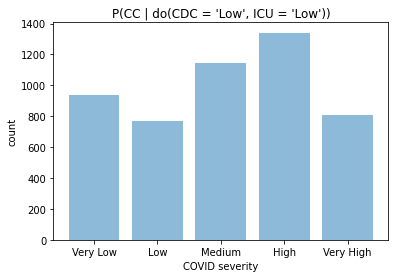

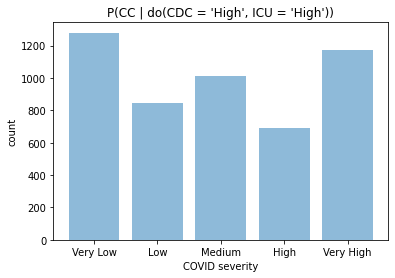

In [24]:
cdc_low_icu_low = pyro.do(cc_pyro_model, data={'CDC':torch.tensor(1), 'ICU':torch.tensor(1)})
intervention = "P(CC | do(CDC = 'Low', ICU = 'Low'))"
do_importance_sampling(cdc_low_icu_low, intervention)

cdc_high_icu_high = pyro.do(cc_pyro_model, data={'CDC':torch.tensor(0), 'ICU':torch.tensor(0)})
intervention = "P(CC | do(CDC = 'High', ICU = 'High'))"
do_importance_sampling(cdc_high_icu_high, intervention)

**Result:** Outside of the 'Very High' bar in the 2nd chart, we can see that the data generated from these do-interventions agrees with our hypothesis. Namely that higher CDC compliance and ICU bed availability lead to lower COVID risk.

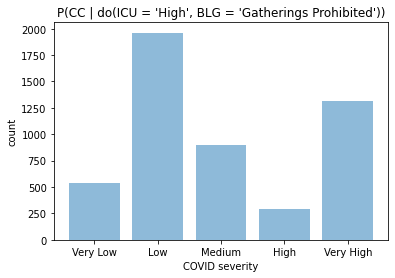

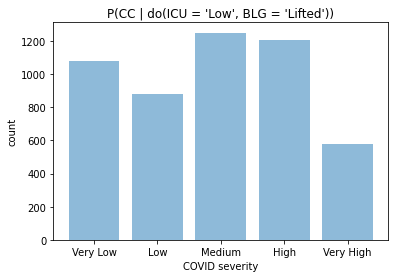

In [32]:
icu_high_blg_prohib = pyro.do(cc_pyro_model, data={'ICU':torch.tensor(0), 'BLG':torch.tensor(1)})
intervention = "P(CC | do(ICU = 'High', BLG = 'Gatherings Prohibited'))"
do_importance_sampling(icu_high_blg_prohib, intervention)

icu_high_blg_lifted = pyro.do(cc_pyro_model, data={'ICU':torch.tensor(1), 'BLG':torch.tensor(2)})
intervention = "P(CC | do(ICU = 'Low', BLG = 'Lifted'))"
do_importance_sampling(icu_high_blg_lifted, intervention)

**Result:** Here we see that higher ICU bed availability and large gatherings prohibited results in much lower COVID risk. However, having low ICU bed availability and a lifted ban on large gatherings has a more mixed distribution. 

Taken together, this suggests that being better prepared for COVID and implementing strategies to combat it could help reduce COVID risk but not doing those things doesn't necessarily raise the risk of COVID.